Epoch 1/2000
2/2 - 0s - loss: 290857.6250
Epoch 2/2000
2/2 - 0s - loss: 267478.2500
Epoch 3/2000
2/2 - 0s - loss: 243769.3125
Epoch 4/2000
2/2 - 0s - loss: 218962.2812
Epoch 5/2000
2/2 - 0s - loss: 183034.7031
Epoch 6/2000
2/2 - 0s - loss: 134040.3750
Epoch 7/2000
2/2 - 0s - loss: 97265.3984
Epoch 8/2000
2/2 - 0s - loss: 59154.0859
Epoch 9/2000
2/2 - 0s - loss: 16639.8613
Epoch 10/2000
2/2 - 0s - loss: 4062.8708
Epoch 11/2000
2/2 - 0s - loss: 7465.9258
Epoch 12/2000
2/2 - 0s - loss: 6001.8906
Epoch 13/2000
2/2 - 0s - loss: 3855.1692
Epoch 14/2000
2/2 - 0s - loss: 1763.6511
Epoch 15/2000
2/2 - 0s - loss: 704.2955
Epoch 16/2000
2/2 - 0s - loss: 372.4955
Epoch 17/2000
2/2 - 0s - loss: 524.0690
Epoch 18/2000
2/2 - 0s - loss: 721.1534
Epoch 19/2000
2/2 - 0s - loss: 740.8948
Epoch 20/2000
2/2 - 0s - loss: 553.4731
Epoch 21/2000
2/2 - 0s - loss: 430.1718
Epoch 22/2000
2/2 - 0s - loss: 401.1346
Epoch 23/2000
2/2 - 0s - loss: 433.8830
Epoch 24/2000
2/2 - 0s - loss: 452.4977
Epoch 25/2000
2/2 - 

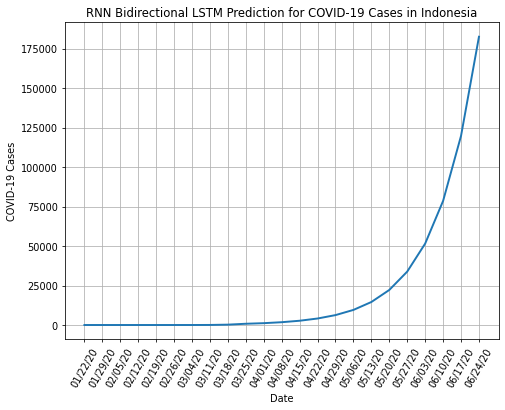

In [9]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
import requests
import datetime as date
import matplotlib.pyplot as plt

#split a univariate (single parameter) sequence 
def split_sequence(seq,n_step,x_train,y_train): # seq: sequence of numbers ; n_step: number of elements to be sliced
  for i in range(len(seq)):
    end_elem = i + n_step #get index of end_elem -1 to be inserted to sliced list (index of final element = end_elem -1)
    if end_elem > len(seq)-1: #check if end_elem is out of bounds
      break
    #create 2 sliced lists => input and output
    sliced_x, sliced_y = seq[i:end_elem], seq[end_elem]
    x_train.append(sliced_x) 
    y_train.append(sliced_y)
  #print(x_train)
  return np.array(x_train), np.array(y_train)

def get_data(country):
  seq = []
  resp = requests.get("https://corona.lmao.ninja/v2/historical/"+ country) #GET HTTP response
  json_result = resp.json() #get json only
  inner_dict = json_result['timeline']['cases'] #get total cases only
  #create list of total cases in a sequential time series
  for k,v in inner_dict.items():
    seq.append(v)
  return seq

def get_data_train(country):
  seq = []
  resp = requests.get("https://corona.lmao.ninja/v2/historical/"+ country) #GET HTTP response
  json_result = resp.json() #get json only
  inner_dict = json_result['timeline']['cases'] #get total cases only
  #create list of total cases in a sequential time series
  for k,v in inner_dict.items():
    if (v != 0):
      seq.append(v)
  return seq

time_series = get_data_train("japan")
time_series_test = get_data("indonesia")

#print(time_series)
#choose number of time steps (length of sliced list)
n_step = 3
#split input sequential time series into samples of sliced lists
x_train, y_train =[],[]
x_train, y_train = split_sequence(time_series, n_step,x_train,y_train)
# reshape from [samples, timesteps] -> [samples, timesteps, features]
n_feature = 1
#print(x_train.shape)
x_train = x_train.reshape((x_train.shape[0],x_train.shape[1],n_feature))
#print(x_train)

#define bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(256, activation='relu'), input_shape=(n_step,n_feature)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

#number of epochs / training
model.fit(x_train, y_train, epochs = 2000, verbose=2)
print(time_series)
print(time_series_test)

#evaluate model
model.evaluate(x_train,y_train,verbose=2)

#run prediction using Indo data
x_test_list = time_series_test[-4:len(time_series_test)-1] #get last 3 elements from time_series list
time_series_pred = time_series_test[:len(time_series_test)-1]
x_test = np.array(x_test_list)

for i in range(90):
  x_test = x_test.reshape((1, n_step, n_feature))
  y_test = model.predict(x_test, verbose=2)
  y_test_rounded = round(y_test[0][0])
  print(y_test_rounded)
  time_series_pred.append(y_test_rounded)
  x_test = np.append(x_test,y_test) #append test result to last element from list
  x_test = np.delete(x_test,0) #delete first element from list

  day = date.datetime(2020,1,22) #day one of infection
day_formatted = day.strftime("%m/%d/%y") #format date

days = []
days.append(day_formatted)
time_series_weekly_pred=[]
#generate days
for i in range(1,len(time_series_pred)):
  day += date.timedelta(days=1)
  day_formatted = day.strftime("%m/%d/%y")
  if ((i % 7) ==0):
    days.append(day_formatted)
print(days)

#create weekly time series pred
for i in range(len(time_series_pred)):
  if ((i%7) == 0):
    time_series_weekly_pred.append(int(time_series_pred[i]))
print(time_series_pred)
print(time_series_weekly_pred)

plt.figure(figsize=(8,6),dpi=70)
plt.ticklabel_format(style='plain')
plt.plot(days,time_series_weekly_pred,linewidth=2)# set x-axis as days and y-axis as number of cases 
plt.xticks(rotation=60) #rotate x-axis label
#name axes
plt.xlabel('Date')
plt.ylabel('COVID-19 Cases')
#name title of graph
plt.title('RNN Bidirectional LSTM Prediction for COVID-19 Cases in Indonesia')
plt.grid()
plt.yscale("linear")
plt.show()